# Tutorial on how to fit emission line and create emission line maps for JWST/NIRSPEC IFS with QubeSpec

## Extracting galaxy integrated spectrum and fitting the emission lines.

Lets start with importing basic libraries. This is a start of every code I write. 

In [23]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle

import Graph_setup as gst 

nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23

Ken98= (4.5*10**-44)
Conversion2Chabrier=1.7 # Also Madau
Calzetti12= 2.8*10**-44
arrow = u'$\u2193$' 

%load_ext autoreload
%autoreload 2

PATH= '/Users/jansen/My Drive/Astro/' # My general path for stuff
fsz = gst.graph_format()

import IFU_tools_class as IFU
import Plotting_tools_v2 as emplot
import Fitting_tools_mcmc as emfit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting 1D spectrum from the IFU cube

1) First we need to import the cube. We have to give it the following information: 

- Path to the cube
- redshift - quite accurate ideally within 0.02
- Path to a folder where we can save the products
- ID 
- Instrument - NIRSPEC_IFU (Jy units), NIRSPEC_IFU_fl (egs/cm/micron), 'KMOS', 'SINFONI'
- band - only applicable to KMOS and SINFONI 
- normalization - multiplication factor to make the 1D spectrum close to 0.1-10 - it makes the code happier

2) Mask JWST

- Masking bad pixels by looking at pixels with very high error - no longer needed after the improvment in bad pixel rejections
- For masking skylines use stack_sky function - talk to me if interested

3) collapse white - makes a white light/continuum map

4) find center 

- finds a center by fitting a 2D Gaussian to the white light image.
- sometimes can fail when complex morphology - like Gareth's galaxy 
- can use manual=[X,Y] to give coordinates

5) Choose pixels - function which select spaxels to collapse into 1D spectrum
- rad  in arcseconds 
- can go manual_mask and pass it = manual_mask= 2D array (True- not including, False means including the spxels)

6) D1_spectrum_collapse - creates a 1D spectrum with errors and applies masks of bad pixels 
- addsave - it also saves the spectrum - can add additional string to the name when saving multiple spectra
- err_range - wvaelength range where it should calculate the error from 
    - if left blank - caluclates it from 3 sigma clipped spectrum
    - if two values - caluclates it as 3sigma clipped from spectrum between wavelength range
    - if 4 values - calculates 2 seperate error values and applies to spaxel before and after the boundary wavalength - applie to NIRSPEC obs with multiple setups
    
   

Set DATE-AVG to '2022-08-26T21:06:16.023' from MJD-AVG.
Set DATE-END to '2022-08-26T23:18:28.809' from MJD-END'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-26T21:06:16.023' from MJD-AVG.
Set DATE-END to '2022-08-26T23:18:28.809' from MJD-END'.
Set OBSGEO-B to   -21.606940 from OBSGEO-[XYZ].
Set OBSGEO-H to 1537709966.572 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.606940 from OBSGEO-[XYZ].
Set OBSGEO-H to 1537709966.572 from OBSGEO-[XYZ]'.


Masking edges based on 0.1 scale
location of the peak on the continuum (array([28]), array([26]))
Initial guesses (0.019407775, 26, 28, 1, 1, 0, 0)
Cont loc  [26.01966954 28.0110606 ]
Cont loc er [0.07401613 0.0687855 ]
Center of cont [26.01966954 28.0110606 ]
Extracting spectrum from diameter 0.3 arcseconds
Pixel scale: 10.0
radius  1.5


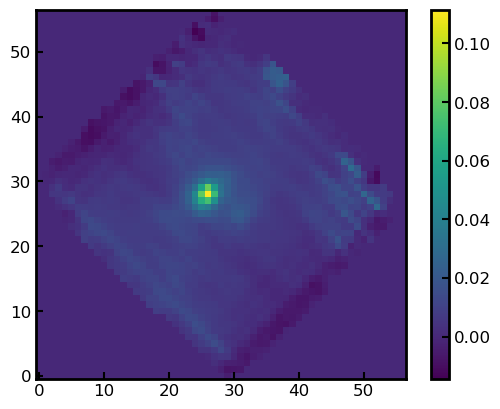

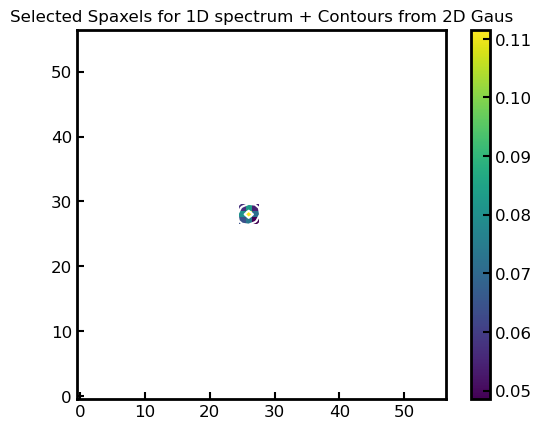

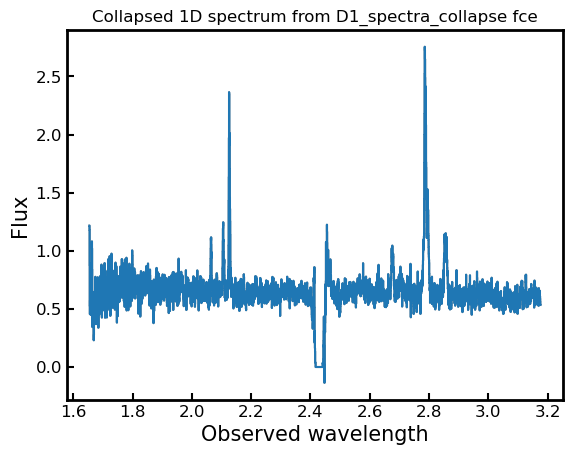

In [24]:
Cube_path = PATH+'JWST/Data/GTO/GA20936/Madrid/20936-GS-3.25-S_jw1216_o003_woff_px0.1_emsm_wODfde95 _wCR4_wVBC_wSJC_wSPC_wCTX1000.pmap_g235h-f170lp_extfluxcal_s3d.fits'
z_initial = 3.2477
ID = 'GS-20936'
Instrument_flag = 'NIRSPEC_IFU_fl'
Save_path = PATH+'JWST/Data/GTO/'
band = 'NIRSPEC'
normalization = 1e-15
plot_it = 1
Cube = IFU.Cube( Cube_path, z_initial, ID, Instrument_flag, Save_path , band, norm=normalization)

error_typical = 1000
Cube.mask_JWST(plot_it, threshold=error_typical*1000/normalization)#, spe_ma=[1295,1296,1070,1071,2357,2358,2359,2360])
#Cube.background_sub_spec(center = [20,20], rad=0.6)
Cube.collapse_white(plot_it)

Cube.find_center(plot_it) # , manual=[26,28]
Cube.choose_pixels(plot_it, rad= 0.15)
Cube.D1_spectra_collapse(plot_it, addsave='', err_range=[2.17,2.26,2.6,2.76], boundary=2.4)
plt.show()




# Fitting Halpha emission line complex
Lets start with Halpha

Options for the AGN are:
- 'BLR' fits type 1 and type 2 options and picks the best - chooses the best based on BIC 
- 'Outflow' - fits type 2 and type 2 with an outflow in Halpha and [NII] - chooses the best based on BIC  
- 'Single_only', 'BLR_only', 'Outflow_only' - fits only one of the models - saves time    
- 'QSO_BKPL' - it fits brokenpowerlaw QSO model. 

Prior information are given as dictionary - currently flat priors between boundries - working on a proper gaussian and flat and other distribution

N = value of number of steps in the emcee fitting 
    

100%|████████████████████████████████████| 10000/10000 [00:19<00:00, 509.14it/s]


Delta BIC 356.2692851640054  
SNR hal  89.86806827760027
SNR SII  31.70735622136069


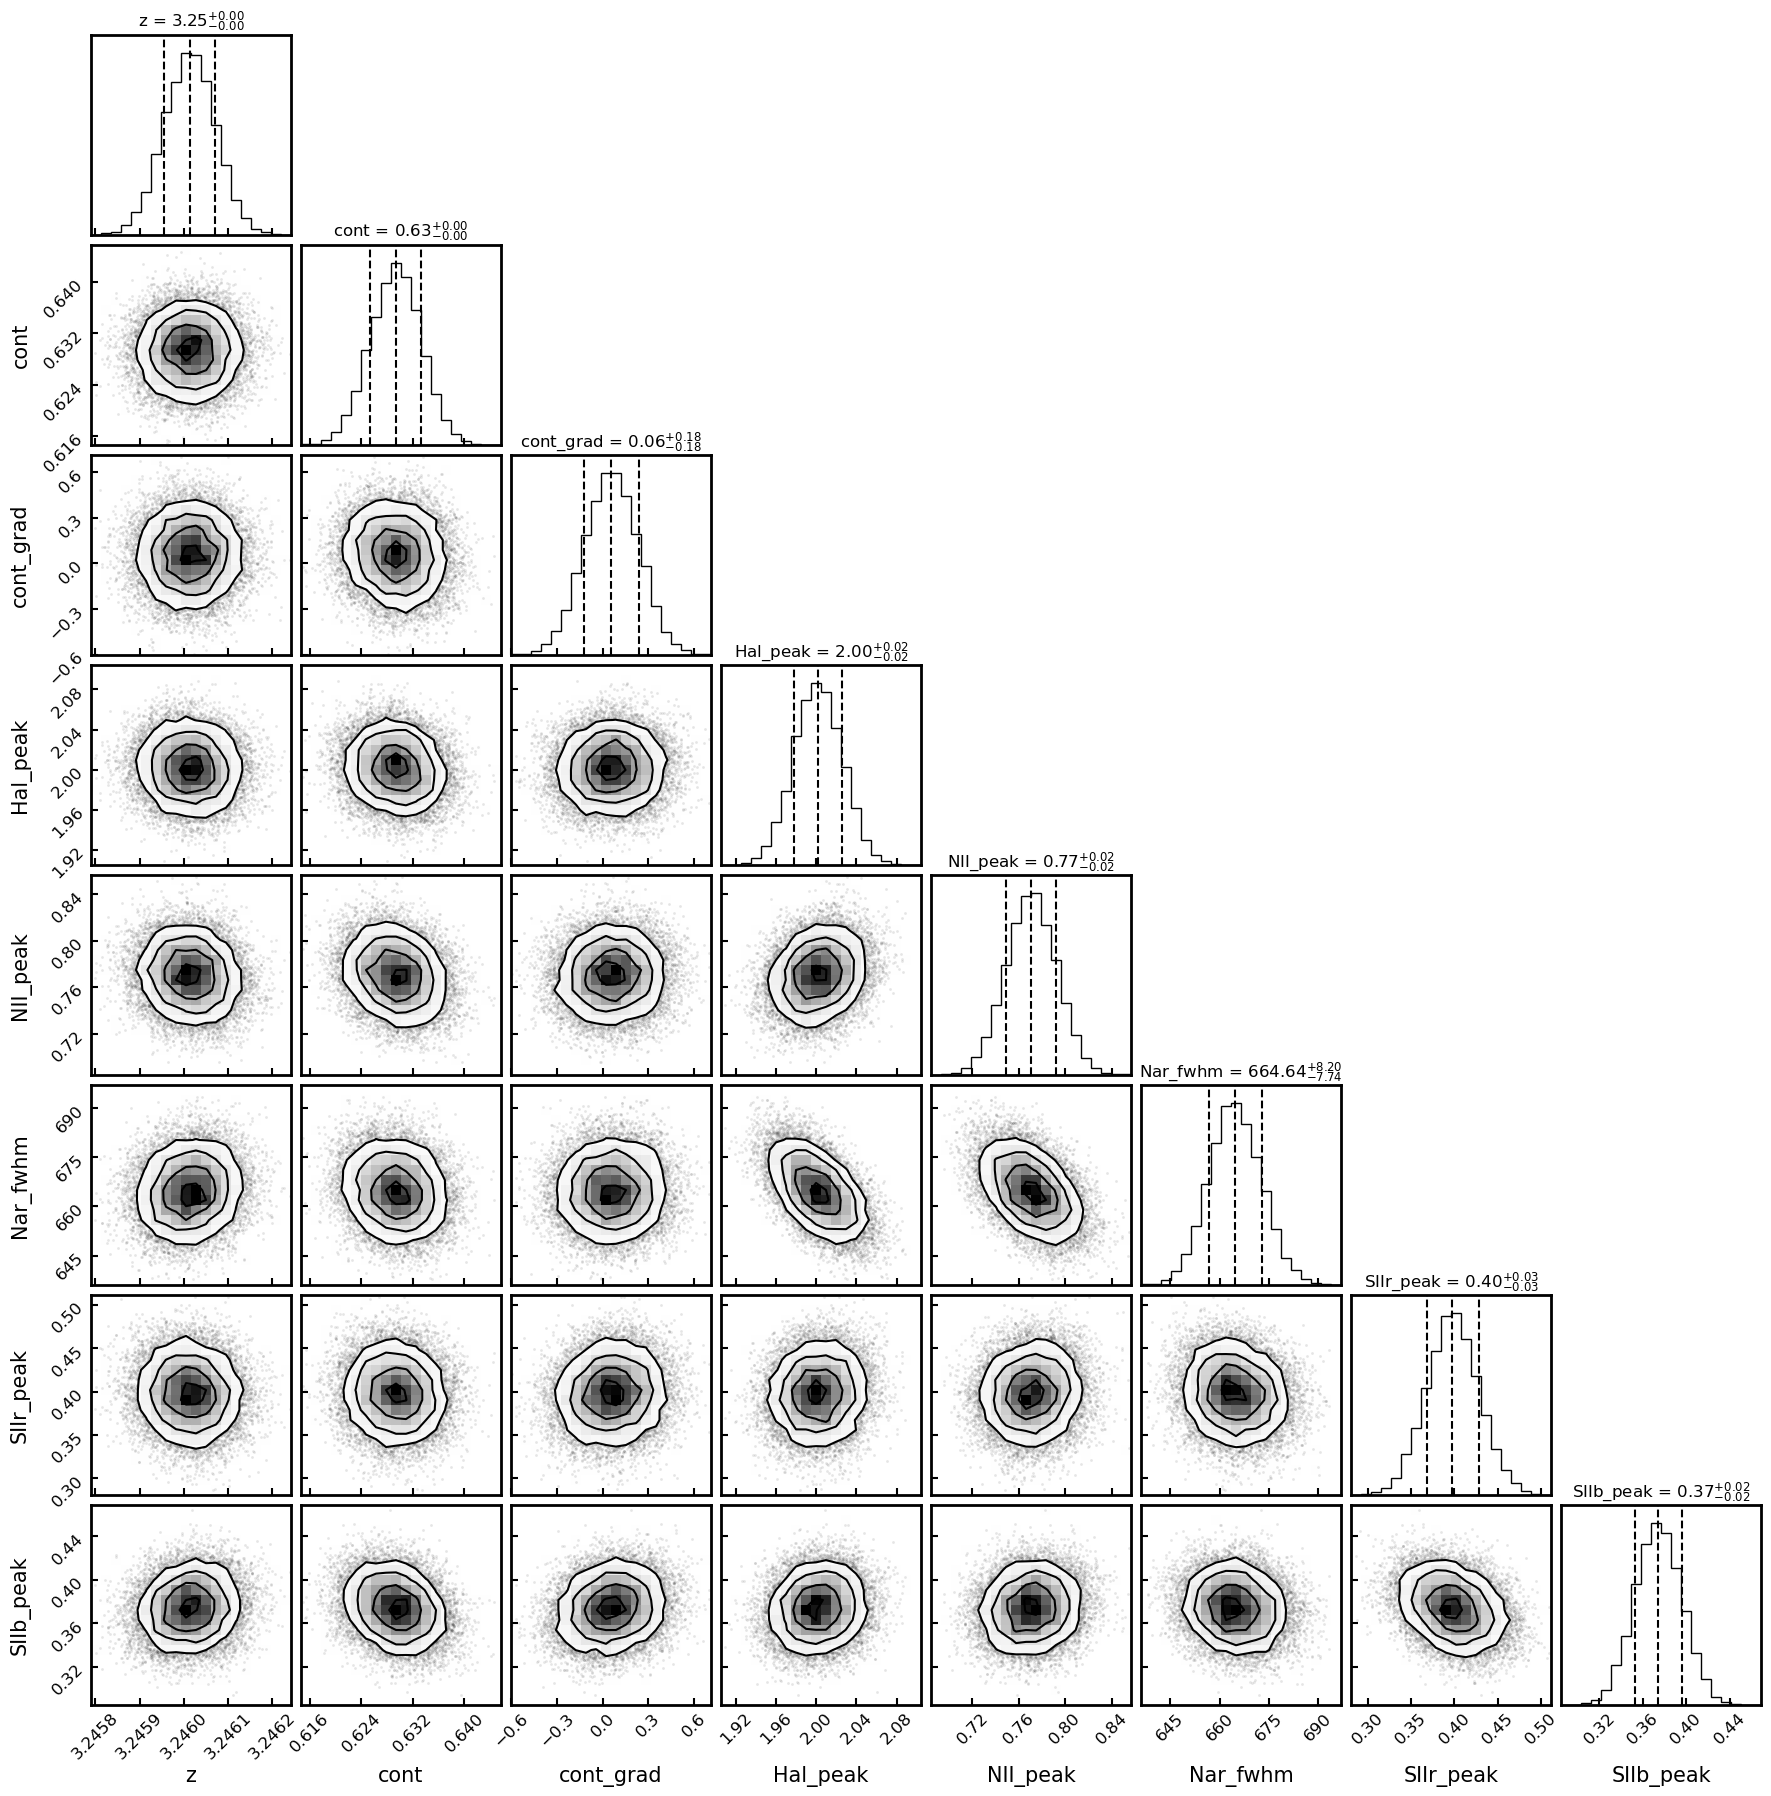

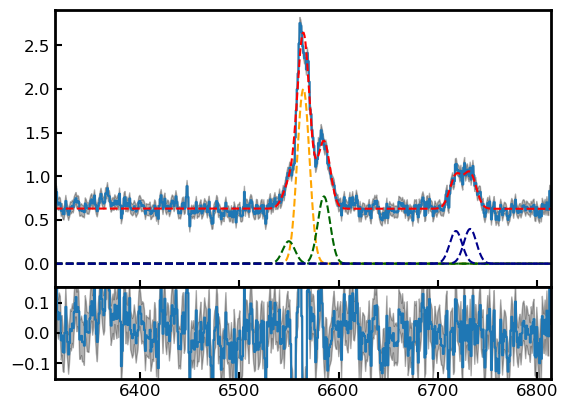

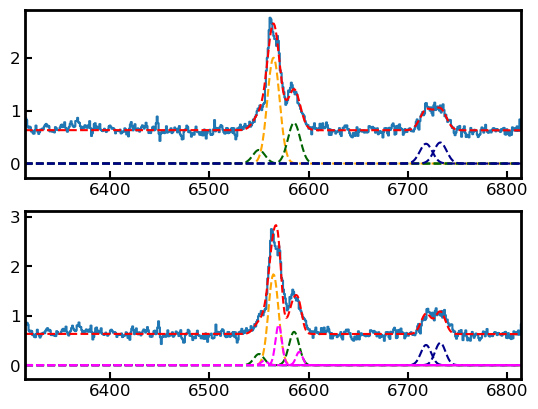

{'name': 'Halpha_wth_BLR', 'z': array([3.24601372e+00, 5.88728387e-05, 5.74179248e-05]), 'cont': array([0.62943461, 0.00404038, 0.00383941]), 'cont_grad': array([0.0568255 , 0.1794433 , 0.17870661]), 'Hal_peak': array([2.00147952, 0.02366065, 0.02440686]), 'NII_peak': array([0.77067582, 0.02164133, 0.02156249]), 'Nar_fwhm': array([664.64016403,   7.73948144,   8.20310699]), 'SIIr_peak': array([0.39789544, 0.02985025, 0.03057877]), 'SIIb_peak': array([0.37429657, 0.02145671, 0.02176036]), 'popt': [3.24601372017107, 0.6294346090554811, 0.05682550035456119, 2.0014795171569197, 0.7706758189359222, 664.6401640274448, 0.39789544369494856, 0.37429656920139726]}
Flux Halpha  (1.315716392976661e-17, 2.5117712108859234e-19, 1.7620500507704228e-19)
Flux NII  (6.796264507726795e-18, 2.24991018141615e-19, 1.9714979767355182e-19)
Flux SIIr (2.6757426354198447e-18, 2.0448378862658018e-19, 2.778679211540864e-19)
Flux SIIb (2.5132282797647214e-18, 1.1350986966722575e-19, 1.5451233518832072e-19)


In [45]:
priors={'z':[0,'normal', Cube.z, 0.001]}
priors['cont']=[0,'loguniform', -3,1]
priors['cont_grad']=[0,'normal', 0,0.2]
priors['Hal_peak']=[0,'loguniform', -3,1]
priors['NII_peak']=[0,'loguniform', -3,1]
priors['Nar_fwhm']=[300,'uniform', 200,900]
priors['SIIr_peak']=[0,'loguniform', -3,1]
priors['SIIb_peak']=[0,'loguniform', -3,1]
priors['OIII_peak']=[0,'loguniform', -3,1]
priors['Hbeta_peak']=[0,'loguniform', -3,1]
priors['OI_peak']=[0,'loguniform', -3,1]
priors['outflow_fwhm']=[450,'uniform', 300,900]
priors['outflow_vel']=[-50,'normal', -50,100]
priors['Hal_out_peak']=[0,'loguniform', -3,1]
priors['NII_out_peak']=[0,'loguniform', -3,1]
priors['OIII_out_peak']=[0,'loguniform', -3,1]
priors['OI_out_peak']=[0,'loguniform', -3,1]
priors['Hbeta_out_peak']=[0,'loguniform', -3,1]

Cube.fitting_collapse_Halpha(plot_it, models='Outflow', priors=priors,N=10000)
plt.show()


print(Cube.D1_fit_results)
print('Flux Halpha ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Han', Cube.flux_norm))
print('Flux NII ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'NII', Cube.flux_norm))
#print('Flux OIII ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OIIIt', Cube.flux_norm))
#print('Flux nar hbeta', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Hbeta', Cube.flux_norm))
#print('Flux OI', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OI', Cube.flux_norm))
print('Flux SIIr', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIr', Cube.flux_norm))
print('Flux SIIb', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIb', Cube.flux_norm))


# Fitting [OIII] + Hbeta complex only

outflow = 'both' fits [OIII] with and without a broad component and picks the best based on BIC


        = 'single' - fits a single gaussian to [OIII]
        
        = 'outflow' - fits 2 gaussians only to [OIII]
        
        = 'QSO'/'QSO_BKP' - it fits 

Hbeta_dual - 0/1 fits one or two gaussians to the Hbeta - ideal for AGN with visible BLR region. 

template Fe templates for 
- 0 no FeII template
- 'Veron', 'BG92', 'Tsuzuki' - fits one of these FeII templates
- no point fitting FeII templates here - we dont see BLR 
        
Prior information are given as dictionary - currently flat priors between boundries - working on a proper gaussian and flat and other distribution

N = value of number of steps in the emcee fitting 
    

100%|████████████████████████████████████| 10000/10000 [00:47<00:00, 210.60it/s]


Delta BIC -112.63862615792539  
['name', 'z', 'cont', 'cont_grad', 'OIII_peak', 'OIII_out_peak', 'Nar_fwhm', 'outflow_fwhm', 'outflow_vel', 'Hbeta_peak', 'Hbeta_fwhm', 'Hbeta_vel', 'popt']


59.176834552449996
11.147234393766889


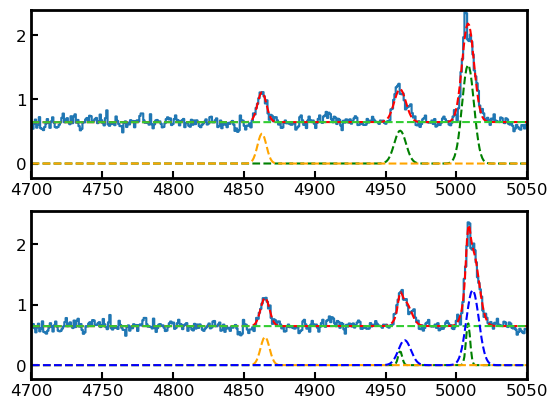

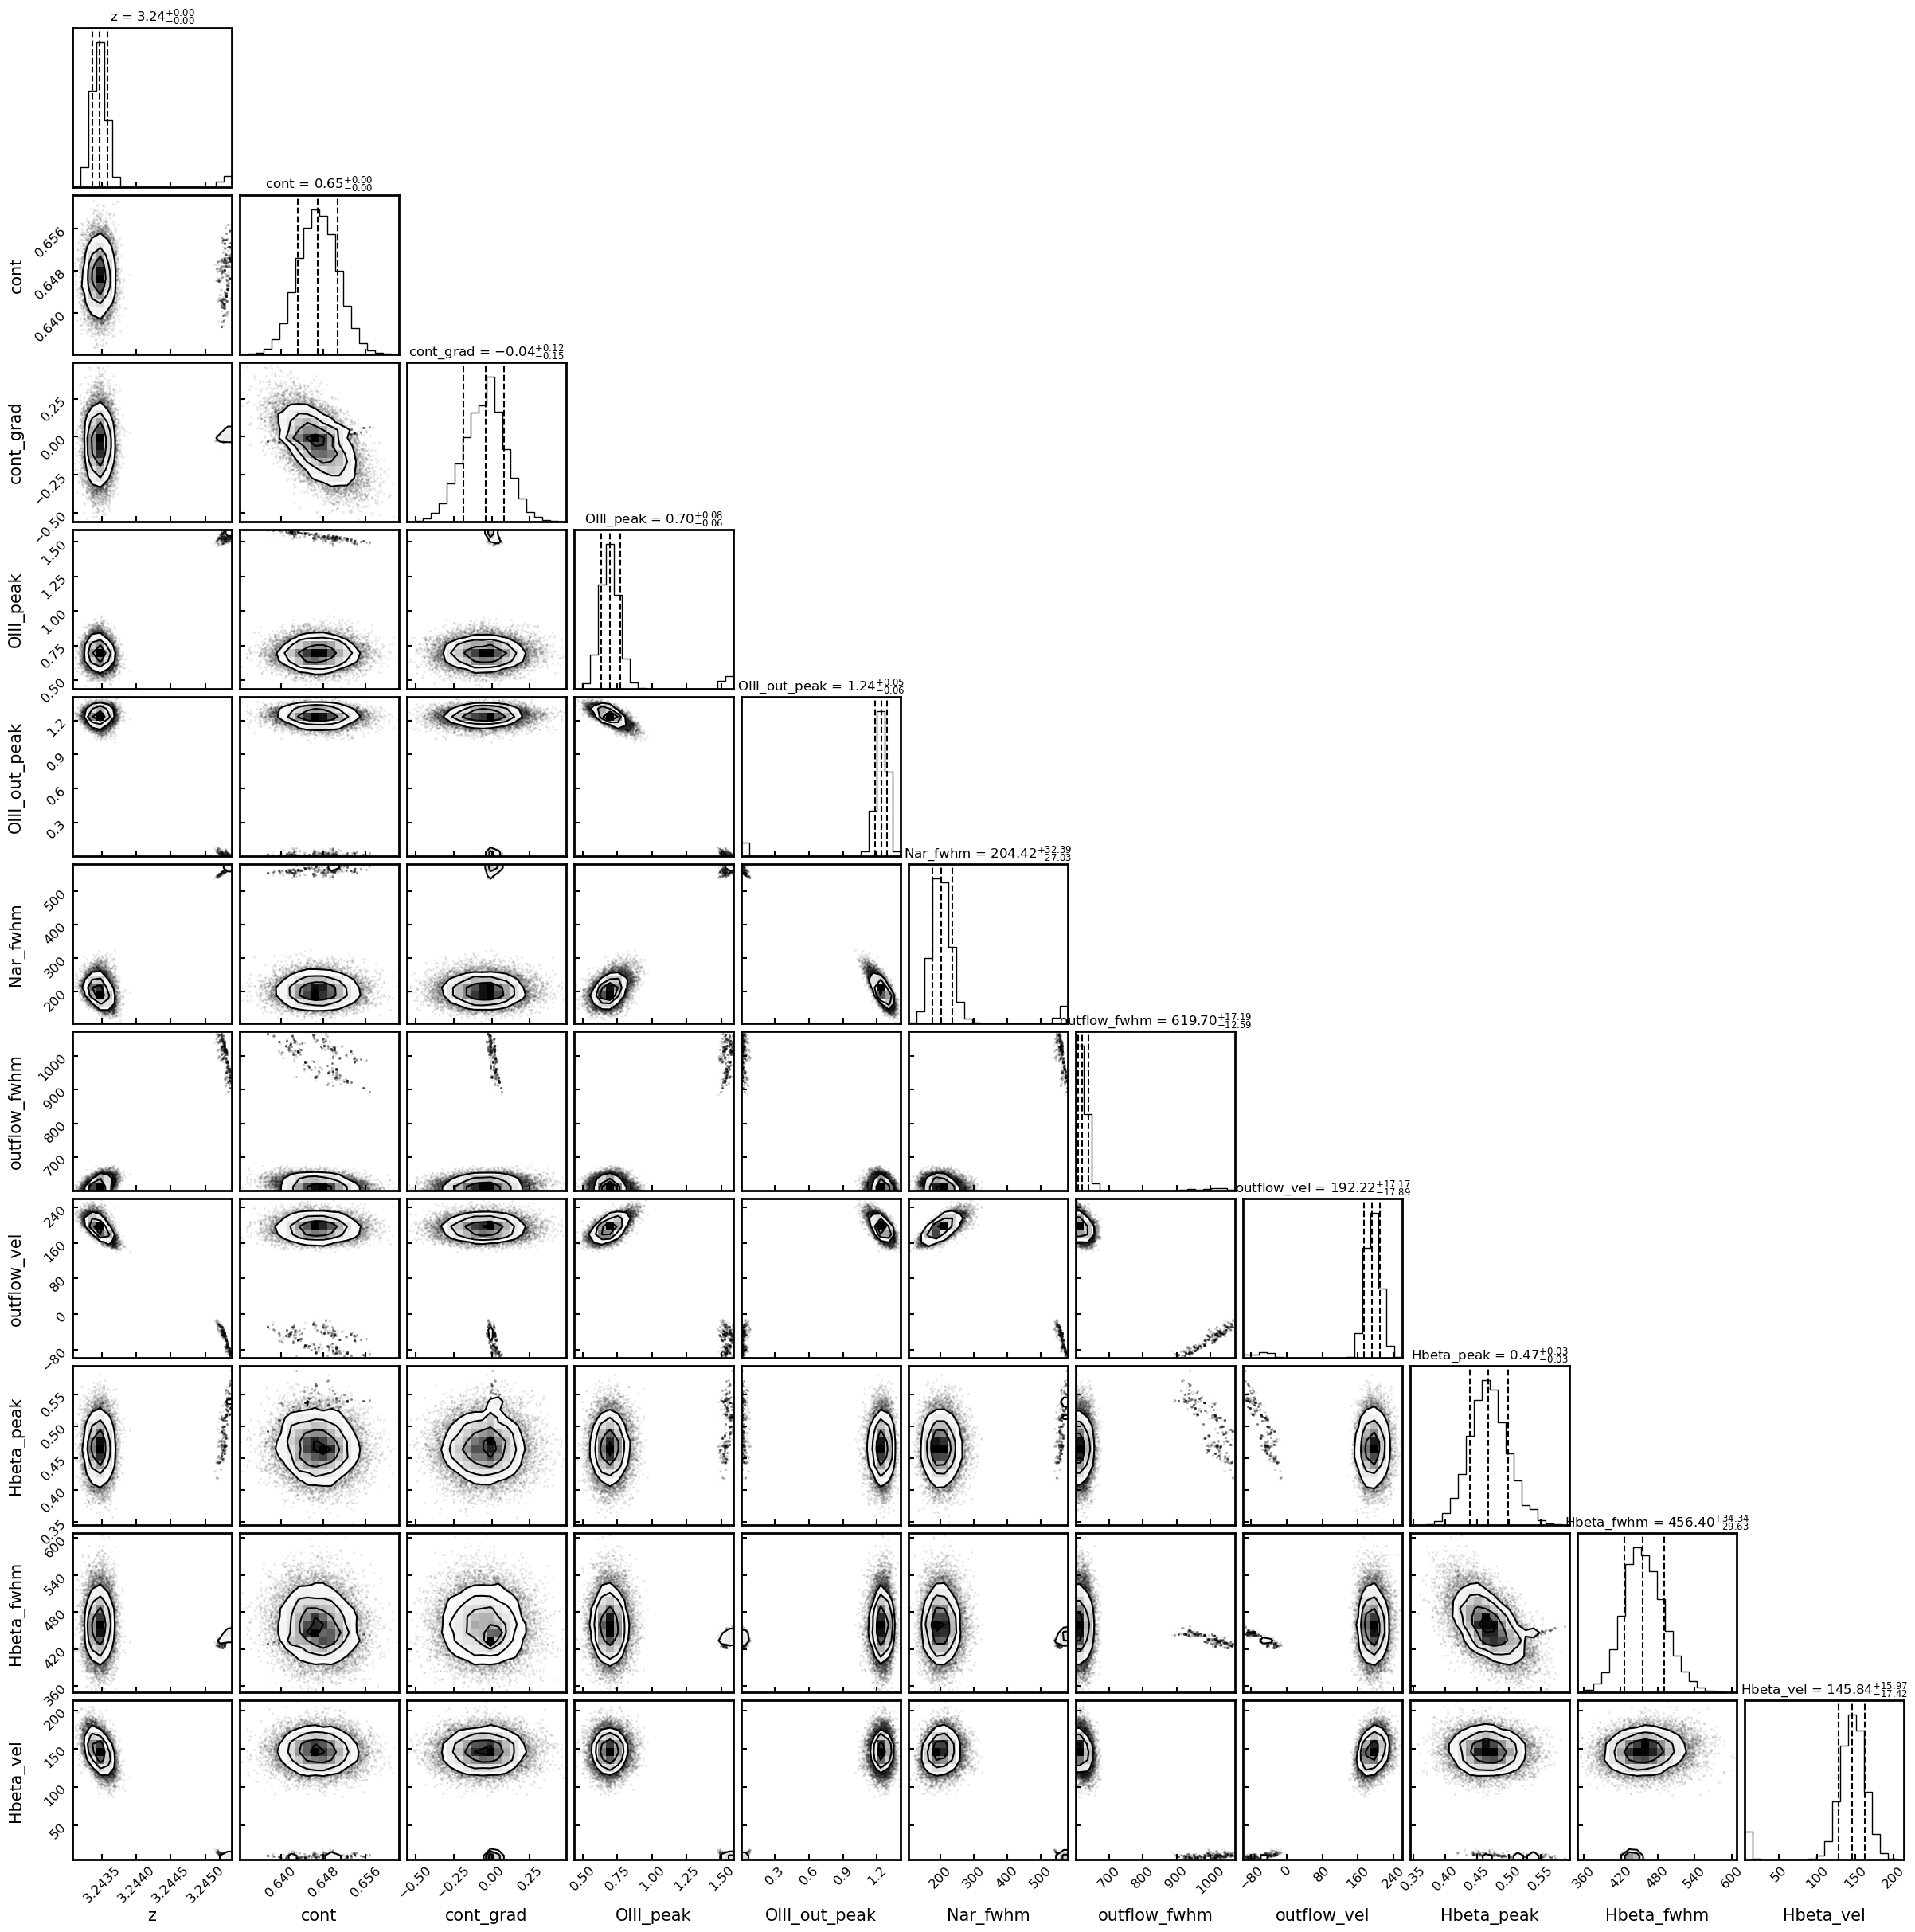

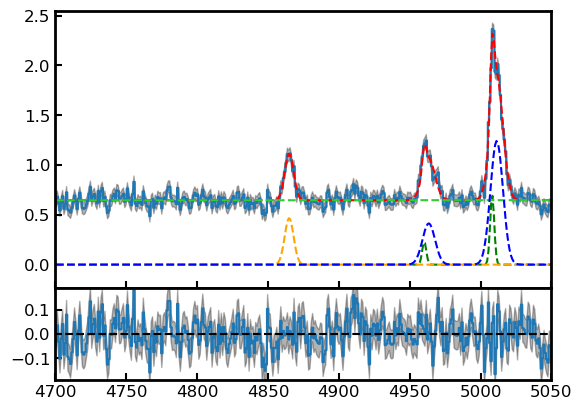

{'name': 'OIII_outflow', 'z': array([3.24346883e+00, 1.02072660e-04, 1.14417449e-04]), 'cont': array([0.64696857, 0.00373434, 0.00369809]), 'cont_grad': array([-0.03923032,  0.14550831,  0.12192464]), 'OIII_peak': array([0.69672792, 0.06451476, 0.07538349]), 'OIII_out_peak': array([1.24197997, 0.05877121, 0.04655664]), 'Nar_fwhm': array([204.42143929,  27.02620695,  32.38979503]), 'outflow_fwhm': array([619.69559993,  12.5949637 ,  17.19010107]), 'outflow_vel': array([192.21555186,  17.88870709,  17.16514785]), 'Hbeta_peak': array([0.46762405, 0.02836222, 0.03088077]), 'Hbeta_fwhm': array([456.40189633,  29.62900329,  34.34354727]), 'Hbeta_vel': array([145.84135417,  17.42336197,  15.96860038]), 'popt': [3.2434688348341516, 0.6469685732909001, -0.03923031969486557, 0.6967279186347207, 1.2419799680556598, 204.4214392948408, 619.695599930642, 192.21555185761872, 0.46762404754122755, 456.401896326356, 145.84135416913034]}
Flux OIII  (9.230821555040166e-18, 5.043152913433175e-19, 6.6084998

In [46]:
priors= {'z': [0,'normal',0, 0.003],\
         'cont':[0,'loguniform',-3,1],\
         'cont_grad':[0,'normal',0,0.2], \
         'OIII_peak':[0,'loguniform',-3,1],\
         'OIII_out_peak':[0,'loguniform',-3,1],\
         'Nar_fwhm':[300,'uniform', 100,900],\
         'outflow_fwhm':[700,'uniform',600,2500],\
         'outflow_vel':[-50,'normal',0,200],\
         'Hbeta_peak':[0,'loguniform',-3,1],\
         'Hbeta_fwhm':[400,'uniform',120,7000],\
         'Hbeta_vel':[10,'normal', 0,200],\
         'Hbetan_peak':[0,'loguniform',-3,1],\
         'Hbetan_fwhm':[300,'uniform',120,700],\
         'Hbetan_vel':[10,'normal', 0,100],\
         'Fe_peak':[0,'loguniform',-3,1],\
         'Fe_fwhm':[3000,'uniform',2000,6000]}

Cube.fitting_collapse_OIII(plot_it, models='Outflow', Hbeta_dual=0, N=10000)
plt.show()

print(Cube.D1_fit_results)

print('Flux OIII ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OIIIt', Cube.flux_norm))
print('Flux nar hbeta', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Hbeta', Cube.flux_norm))


# Fitting all emission lines at once

Currently implemented only one model - simpliest without any BLR components 


100%|█████████████████████████████████████| 10000/10000 [02:04<00:00, 80.58it/s]


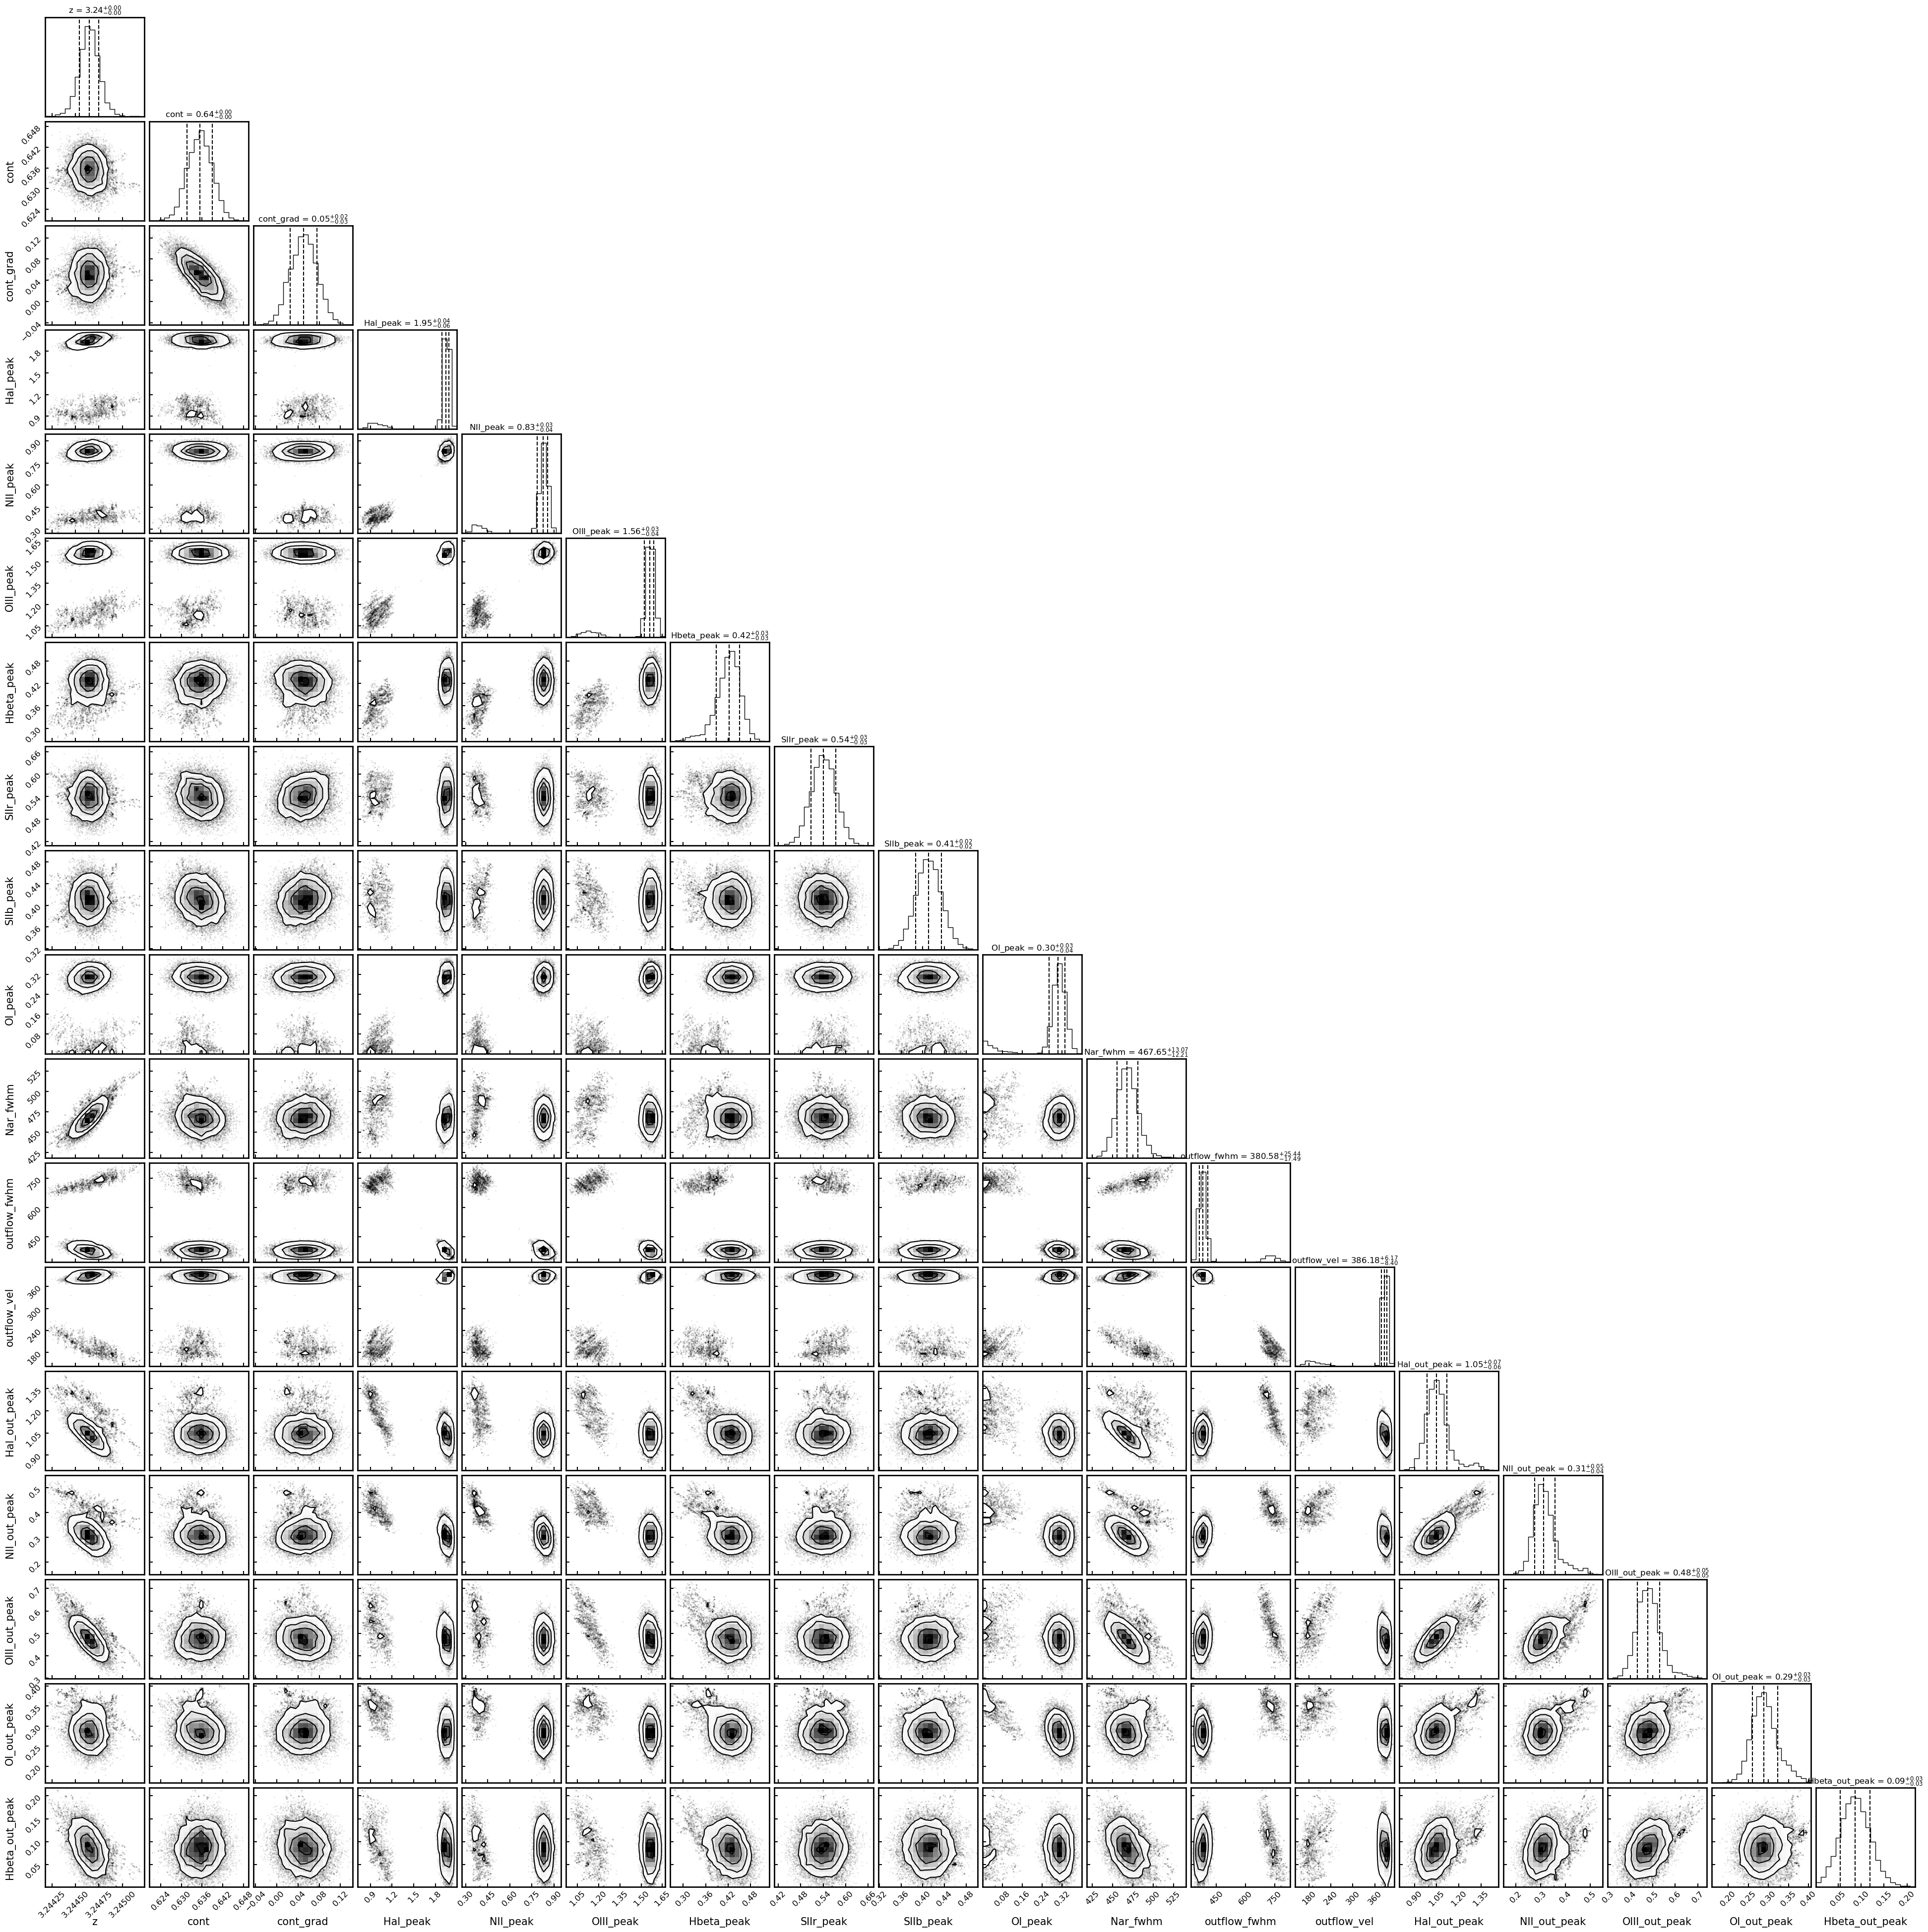

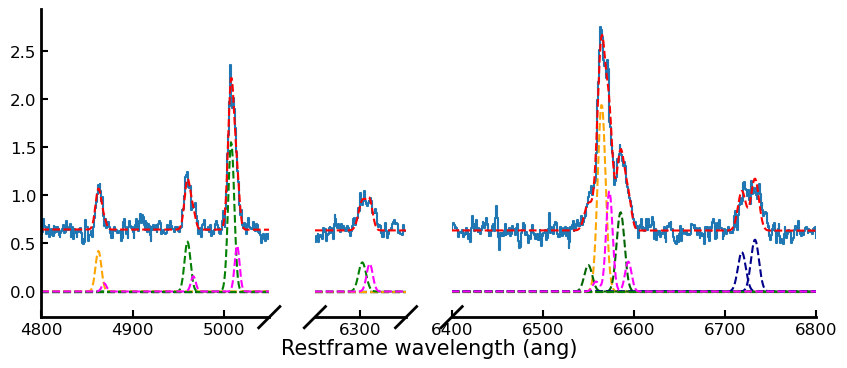

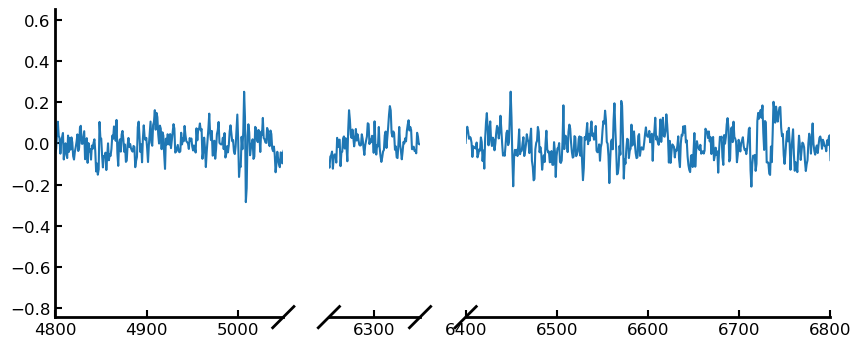

In [47]:
priors={'z':[0,'normal', 0, 0.003],\
        'cont':[0,'loguniform', -3,1],\
        'cont_grad':[0,'normal', 0,0.2],\
        'Hal_peak':[0,'loguniform', -3,1],\
        'NII_peak':[0,'loguniform', -3,1],\
        'Nar_fwhm':[300,'uniform', 200,900],\
        'SIIr_peak':[0,'loguniform', -3,1],\
        'SIIb_peak':[0,'loguniform', -3,1],\
        'OIII_peak':[0,'loguniform', -3,1],\
        'Hbeta_peak':[0,'loguniform', -3,1],\
        'OI_peak':[0,'loguniform', -3,1],\
        'outflow_fwhm':[450,'uniform', 300,900],\
        'outflow_vel':[-50,'normal', -50,100],\
        'Hal_out_peak':[0,'loguniform', -3,1],\
        'NII_out_peak':[0,'loguniform', -3,1],\
        'OIII_out_peak':[0,'loguniform', -3,1],\
        'OI_out_peak':[0,'loguniform', -3,1],\
        'Hbeta_out_peak':[0,'loguniform', -3,1],\
        'zBLR':[0,'normal', 0,0.003],\
        'BLR_fwhm':[4000,'normal', 5000,500],\
        'BLR_Hal_peak':[0,'loguniform', -3,1],\
        'BLR_Hbeta_peak':[0,'loguniform', -3,1],}

Cube.fitting_collapse_Halpha_OIII(plot_it,N=10000, models='Outflow_only', priors=priors)

plt.show()

We can extract some information from fits

- Print the fitting results - Cube.D1_fit_results
- we can also access the chains - Cube.D1_fit_chains

We can also calculate the fluxes as shown below - Warning - make sure you supply the normalization of the cube with Cube.flux_norm

In [44]:
print(Cube.D1_fit_results)
print('Flux Halpha ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Han', Cube.flux_norm))
print('Flux NII ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'NII', Cube.flux_norm))
print('Flux OIII ', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OIIIt', Cube.flux_norm))
print('Flux nar hbeta', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'Hbeta', Cube.flux_norm))
print('Flux OI', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'OI', Cube.flux_norm))
print('Flux SIIr', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIr', Cube.flux_norm))
print('Flux SIIb', IFU.sp.flux_calc_mcmc(Cube.D1_fit_results, Cube.D1_fit_chain, 'SIIb', Cube.flux_norm))


{'name': 'Halpha_OIII_outflow', 'z': array([3.24479220e+00, 2.46285189e-04, 2.35237442e-03]), 'cont': array([0.63488125, 0.00363025, 0.0038468 ]), 'cont_grad': array([0.04733886, 0.02694784, 0.02483998]), 'Hal_peak': array([1.74205189, 0.10621866, 0.22600606]), 'NII_peak': array([0.64122389, 0.200667  , 0.189321  ]), 'OIII_peak': array([1.39047338, 0.39328765, 0.17175768]), 'Hbeta_peak': array([0.37391271, 0.09906801, 0.06284213]), 'SIIr_peak': array([0.50317622, 0.08362716, 0.05303288]), 'SIIb_peak': array([0.40468833, 0.025158  , 0.02600329]), 'OI_peak': array([0.31844427, 0.15085417, 0.04790056]), 'Nar_fwhm': array([493.69683981,  29.88860431, 149.64341086]), 'outflow_fwhm': array([373.19749804,  69.4744706 , 326.77735543]), 'outflow_vel': array([207.20192925, 459.65045374, 180.86040126]), 'Hal_out_peak': array([0.93145406, 0.22792464, 0.15201163]), 'NII_out_peak': array([0.32802813, 0.04770329, 0.08048195]), 'OIII_out_peak': array([0.53105884, 0.10456206, 0.41121354]), 'OI_out_peak

## Spaxel-by Spaxel fit prep

Lets now applly all of these things to spaxel by spaxel fitting. 

No point in doing this for the whole cube - only spaxel where galaxy should be. (otherwise we will be fitting 2500 spectra)

We can either say:
- lets pick a circular mask by giving the code rad= XY arcseconds - great for Hannah's galaxy
- Supply a manual mask - easy to define using cv2 library - example below

You can also specify add='some string' if you want to add some extra part to the name of the file

The error calculation is estimated same as for 1D spectrum

This next function will unwrap the cube and save it to make it ready for spaxel-by-spaxel fitting

This will also bin the pixels as median of the neighborouring spaxel to improve SNR without a loss of resolution. 



[57, 57, 3844]


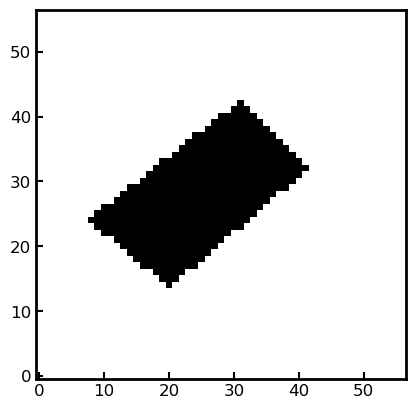

In [10]:
import cv2

dims = Cube.dim
print(dims)
x = np.ones((dims[0], dims[1]), dtype=np.uint8)
pts = np.array([[8,24],
[20,14],
[41,32],
[31,42]], np.int32).reshape(-1, 1, 2)

mask = cv2.fillPoly(x,[pts],0)
plt.imshow(mask, cmap='gray', origin='lower')

plt.show()

Unwrapping = False
if Unwrapping==True:
    
    Cube.unwrap_cube(rad=0.3, instrument='NIRSPEC',mask_manual=mask, err_range=[2.17,2.26,2.6,2.76], boundary=2.4) 
    

We will now fit the saved spaxels. 

- You can supply prior list as usual. priors= dictionary...
- Ncore - number of core to use during fit - by default it will use number of cores on your machine - 2 
- you can specify add='' to load that specific unwrapped spaxels. It will then save the file with the add string in it. This enables you to fit two seperate regions with seperate priors - redshifts (Gareth's galaxy) and then merge them together again. 
- BLR - you can either specify - 'None' fits no outflow or BLR, 'outflow_both' - fits both outflow and non outflow model and pick the best and 'BLR' - fits a BLR model with outflows

In [11]:
'''
priors={'z':[0,'normal', 0, 0.003],\
        'cont':[0,'loguniform', -3,1],\
        'cont_grad':[0,'normal', 0,0.2],\
        'Hal_peak':[0,'loguniform', -3,1],\
        'NII_peak':[0,'loguniform', -3,1],\
        'Nar_fwhm':[300,'uniform', 200,900],\
        'SIIr_peak':[0,'loguniform', -3,1],\
        'SIIb_peak':[0,'loguniform', -3,1],\
        'OIIIn_peak':[0,'loguniform', -3,1],\
        'Hbeta_peak':[0,'loguniform', -3,1],\
        'OI_peak':[0,'loguniform', -3,1],\
        'outflow_fwhm':[450,'uniform', 300,900],\
        'outflow_vel':[-50,'normal', -50,100],\
        'Hal_out_peak':[0,'loguniform', -3,1],\
        'NII_out_peak':[0,'loguniform', -3,1],\
        'OIII_out_peak':[0,'loguniform', -3,1],\
        'OI_out_peak':[0,'loguniform', -3,1],\
        'Hbeta_out_peak':[0,'loguniform', -3,1],\
        'zBLR':[0,'normal', 0,0.003],\
        'BLR_fwhm':[4000,'normal', 5000,500],\
        'BLR_hal_peak':[0,'loguniform', -3,1],\
        'BLR_hbe_peak':[0,'loguniform', -3,1],}
'''
Spaxel = False
if Spaxel==True: 
    if __name__ == '__main__':
        Cube.Spaxel_fitting_Halpha_OIII_MCMC_mp(Ncores=8, priors=priors, add='', )


We will now post process the raw fits to the actual maps that we can visualize. The only real variable is the SNR cut. The rest are only to make the fits pretty.

In [30]:
Map_pp = True
 
if Map_pp==True:
    fmaps = Cube.Map_creation_Halpha_OIII(flux_max=1e-19, SNR_cut=3., fwhmrange=[200,700], velrange=[-200,200])
    plt.show()

  0%|▏                                          | 2/632 [00:00<00:59, 10.52it/s]


KeyError: 'SIIr_peak'

If you want to plot the maps without reprocessing all of the raw spaxel fits, you can just pass it a path ot the .fits file containing the maps and it will plot it. 

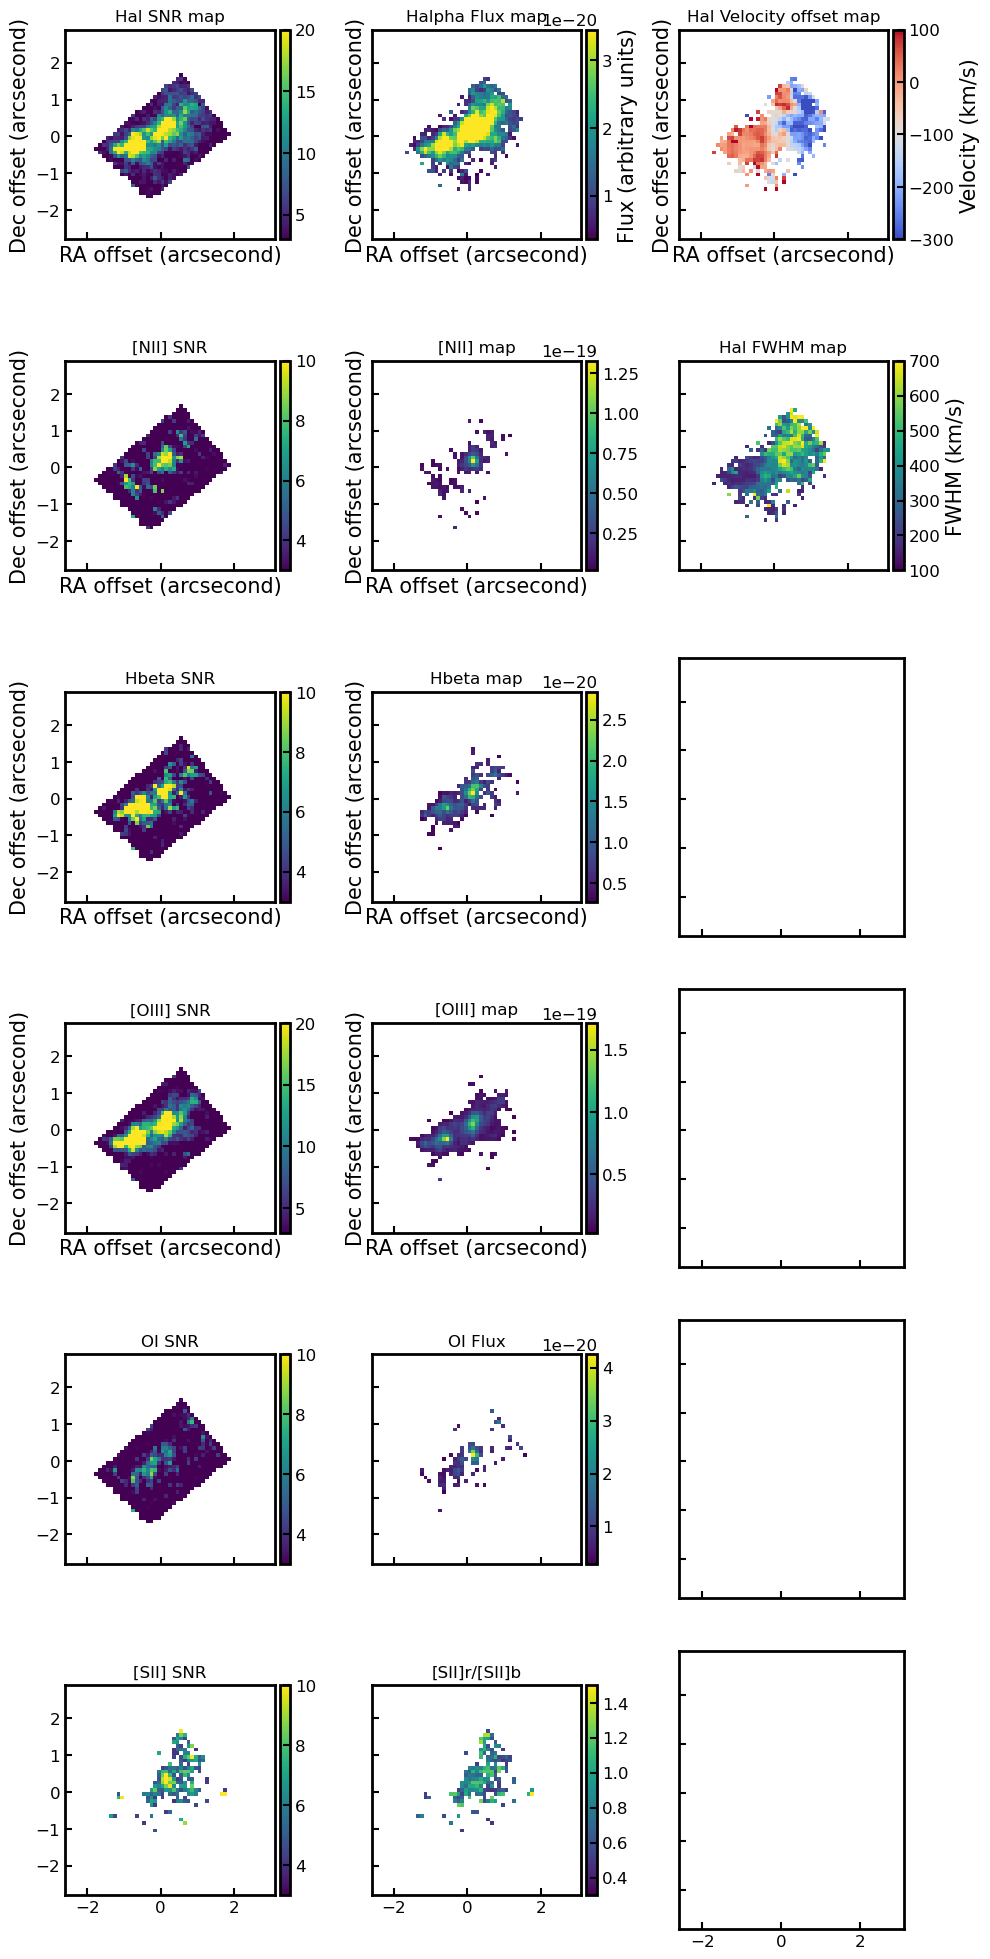

In [32]:

emplot.Plot_results_Halpha_OIII('/Users/jansen/My Drive/Astro/JWST/Data/GTO/GA20936/Madrid/GS-20936_Halpha_OIII_fits_maps_v2.fits', center=[26,28],\
                               velrange=[-300,100], fwhmrange=[100,700])
#fmaps.savefig(PATH+'JWST/Graphs_GS-20936/Hal_OIII_maps_full.pdf')

plt.show()

# Regional spectra

You can also extract and fit regional spectra. Example below: 

Center of cont [19, 24]
Extracting spectrum from diameter 0.5 arcseconds
Pixel scale: 10.0
radius  2.5


100%|██████████████████████████████████████| 6000/6000 [00:43<00:00, 139.04it/s]
/var/folders/zb/_99257zx4mx274sgm4w8j3wh0000gn/T/ipykernel_99123/1219592183.py:44: UserWarning: No contour levels were found within the data range.
  ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))


{'name': 'Halpha_OIII', 'z': array([3.24718466e+00, 1.09902790e-05, 1.07656272e-05]), 'cont': array([0.1946884 , 0.00409628, 0.00415552]), 'cont_grad': array([1.51098841, 0.08666087, 0.08596212]), 'Hal_peak': array([4.32331175, 0.05185029, 0.05126509]), 'NII_peak': array([0.29548165, 0.04849705, 0.04801988]), 'Nar_fwhm': array([2.00210389e+02, 1.57948026e-01, 3.33695118e-01]), 'SIIr_peak': array([0.23044197, 0.05332896, 0.0540207 ]), 'SIIb_peak': array([0.4456896 , 0.04882988, 0.05085628]), 'OIIIn_peak': array([6.68854668, 0.05658826, 0.05569917]), 'Hbeta_peak': array([1.6619508 , 0.05760471, 0.05706249]), 'OI_peak': array([0.46621176, 0.05152148, 0.05373782]), 'popt': [3.247184656246218, 0.19468839951951442, 1.510988405458331, 4.3233117482972405, 0.2954816460563956, 200.21038872376545, 0.23044196996744043, 0.44568959994870583, 6.688546682055824, 1.6619508023729037, 0.46621176179143453], 'Flux_Halpha': (8.559022142770676e-18, 1.0627702865449688e-19, 1.215482188520325e-19), 'Flux_NII': 

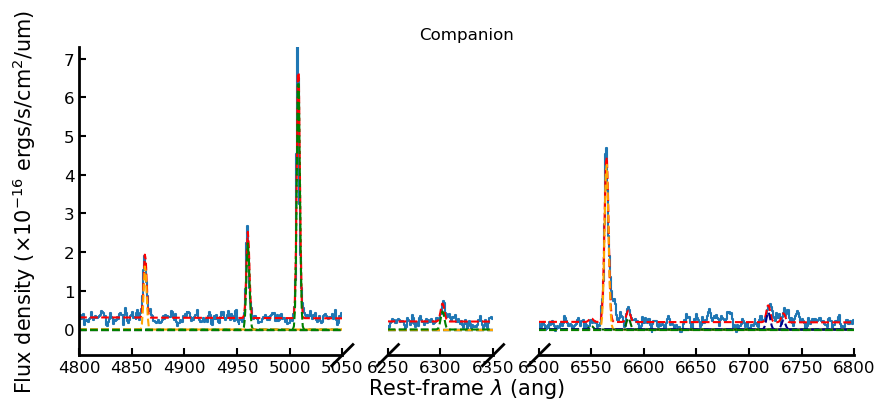

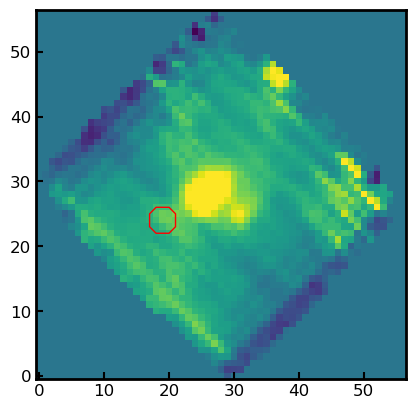

In [34]:
from brokenaxes import brokenaxes
Flux, Flux_er, mask = Cube.Regional_Spec(center=[19,24],rad=0.25,err_range=[2.6,2.76])


priors={'z':[0,'normal', 0, 0.003],\
        'cont':[0,'loguniform', -3,1],\
        'cont_grad':[0,'normal', 0,0.2],\
        'Hal_peak':[0,'loguniform', -3,1],\
        'NII_peak':[0,'loguniform', -3,1],\
        'Nar_fwhm':[300,'uniform', 200,900],\
        'SIIr_peak':[0,'loguniform', -3,1],\
        'SIIb_peak':[0,'loguniform', -3,1],\
        'OIIIn_peak':[0,'loguniform', -3,1],\
        'Hbeta_peak':[0,'loguniform', -3,1],\
        'OI_peak':[0,'loguniform', -3,1],\
        'outflow_fwhm':[450,'uniform', 300,900],\
        'outflow_vel':[-50,'normal', -50,100],\
        'Hal_out_peak':[0,'loguniform', -3,1],\
        'NII_out_peak':[0,'loguniform', -3,1],\
        'OIII_out_peak':[0,'loguniform', -3,1],\
        'OI_out_peak':[0,'loguniform', -3,1],\
        'Hbeta_out_peak':[0,'loguniform', -3,1],\
        'zBLR':[0,'normal', 0,0.003],\
        'BLR_fwhm':[4000,'normal', 5000,500],\
        'BLR_Hal_peak':[0,'loguniform', -3,1],\
        'BLR_Hbeta_peak':[0,'loguniform', -3,1],}

chains, fitted_model = emfit.fitting_Halpha_OIII(Cube.obs_wave, Flux, Flux_er, Cube.z, priors=priors)
sol = IFU.sp.prop_calc(chains)

f = plt.figure(figsize=(10,4))
baxes = brokenaxes(xlims=((4800,5050),(6250,6350),(6500,6800)),  hspace=.01)
emplot.plotting_Halpha_OIII(Cube.obs_wave, Flux,baxes, sol,fitted_model)

baxes.set_title('Companion')
baxes.set_xlabel(r'Rest-frame $\lambda$ (ang)')
baxes.set_ylabel(r'Flux density ($\times 10^{-16}$ ergs/s/cm$^2$/um)')

f,ax =plt.subplots(1)
ax.imshow(Cube.Median_stack_white, origin='lower', vmax=Cube.Median_stack_white.max()*0.2)
mask_plot = mask[0,:,:].copy()
mask_plot[mask_plot==True] = 1
mask_plot[mask_plot==False]= 0
ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))

mask_comp = mask_plot.copy()

sol['Flux_Halpha'] = IFU.sp.flux_calc_mcmc(sol,chains, 'Han', Cube.flux_norm)
sol['Flux_NII'] = IFU.sp.flux_calc_mcmc(sol,chains, 'NII', Cube.flux_norm)
sol['Flux_OIII'] = IFU.sp.flux_calc_mcmc(sol, chains, 'OIIIt', Cube.flux_norm)
sol['Flux_Hb'] = IFU.sp.flux_calc_mcmc(sol,chains, 'Hbeta', Cube.flux_norm)
sol['Flux_OI'] = IFU.sp.flux_calc_mcmc(sol,chains, 'OI', Cube.flux_norm)
sol['Flux_SIIr'] = IFU.sp.flux_calc_mcmc(sol,chains, 'SIIr', Cube.flux_norm)
sol['Flux_SIIb'] = IFU.sp.flux_calc_mcmc(sol,chains, 'SIIb', Cube.flux_norm)
print(sol)
print('Flux Halpha ', sol['Flux_Halpha'])
print('Flux NII ', sol['Flux_NII'])
print('Flux OIII ', sol['Flux_OIII'])
print('Flux hbeta', sol['Flux_Hb'])
print('Flux OI', sol['Flux_OI'])
print('Flux SIIr', sol['Flux_SIIr'])
print('Flux SIIb', sol['Flux_SIIb'])

plt.show()

Center of cont [31, 25]
Extracting spectrum from diameter 0.5 arcseconds
Pixel scale: 10.0
radius  2.5


100%|███████████████████████████████████████| 6000/6000 [03:46<00:00, 26.47it/s]
/var/folders/zb/_99257zx4mx274sgm4w8j3wh0000gn/T/ipykernel_99123/1319836294.py:21: UserWarning: No contour levels were found within the data range.
  ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))


{'name': 'Halpha_OIII', 'z': array([3.24425812e+00, 7.85868265e-05, 7.93737938e-05]), 'cont': array([0.29726956, 0.00436396, 0.00434255]), 'cont_grad': array([1.23847566, 0.0599189 , 0.05793484]), 'Hal_peak': array([1.15774592, 0.03875883, 0.04073179]), 'NII_peak': array([0.20892513, 0.03301836, 0.03298048]), 'Nar_fwhm': array([397.63976801,  14.86276475,  15.57881309]), 'SIIr_peak': array([0.21006976, 0.03386453, 0.03348886]), 'SIIb_peak': array([0.37807079, 0.0345077 , 0.03353627]), 'OIIIn_peak': array([0.65728199, 0.03946309, 0.03961654]), 'Hbeta_peak': array([0.34570277, 0.03932155, 0.03972208]), 'OI_peak': array([0.16343761, 0.03521707, 0.03499031]), 'popt': [3.244258124475433, 0.29726955781135656, 1.2384756647838473, 1.1577459205476084, 0.20892513182259115, 397.6397680065181, 0.21006975679100698, 0.37807079305627667, 0.6572819933089451, 0.3457027739442272, 0.16343760811092328], 'Flux_Halpha': (4.552426104504829e-18, 2.1669898220085386e-19, 2.5142055080756273e-19), 'Flux_NII': (1.

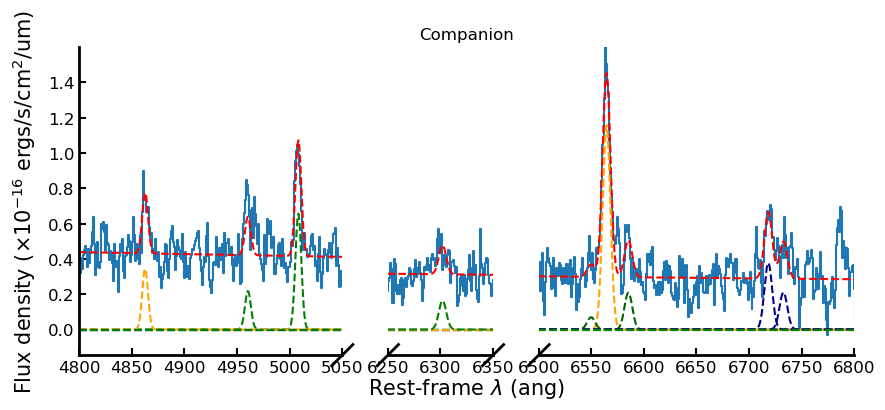

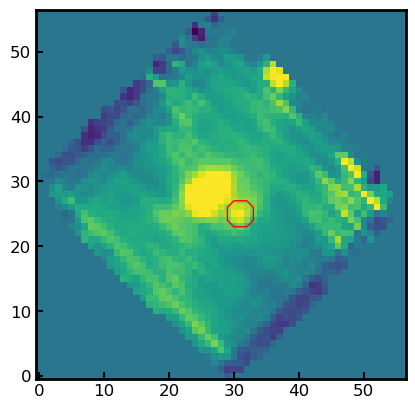

In [35]:
from brokenaxes import brokenaxes
Flux, Flux_er, mask = Cube.Regional_Spec(center=[31,25],rad=0.25,err_range=[2.6,2.76])


chains, fitted_model = emfit.fitting_Halpha_OIII(Cube.obs_wave, Flux, Flux_er, Cube.z, priors=priors)
sol = IFU.sp.prop_calc(chains)

f = plt.figure(figsize=(10,4))
baxes = brokenaxes(xlims=((4800,5050),(6250,6350),(6500,6800)),  hspace=.01)
emplot.plotting_Halpha_OIII(Cube.obs_wave, Flux,baxes, sol,fitted_model)

baxes.set_title('Companion')
baxes.set_xlabel(r'Rest-frame $\lambda$ (ang)')
baxes.set_ylabel(r'Flux density ($\times 10^{-16}$ ergs/s/cm$^2$/um)')

f,ax =plt.subplots(1)
ax.imshow(Cube.Median_stack_white, origin='lower', vmax=Cube.Median_stack_white.max()*0.2)
mask_plot = mask[0,:,:].copy()
mask_plot[mask_plot==True] = 1
mask_plot[mask_plot==False]= 0
ax.contour(mask_plot, colors='red', linewidths=1.0, levels=(0.))

mask_comp = mask_plot.copy()

sol['Flux_Halpha'] = IFU.sp.flux_calc_mcmc(sol,chains, 'Han', Cube.flux_norm)
sol['Flux_NII'] = IFU.sp.flux_calc_mcmc(sol,chains, 'NII', Cube.flux_norm)
sol['Flux_OIII'] = IFU.sp.flux_calc_mcmc(sol, chains, 'OIIIt', Cube.flux_norm)
sol['Flux_Hb'] = IFU.sp.flux_calc_mcmc(sol,chains, 'Hbeta', Cube.flux_norm)
sol['Flux_OI'] = IFU.sp.flux_calc_mcmc(sol,chains, 'OI', Cube.flux_norm)
sol['Flux_SIIr'] = IFU.sp.flux_calc_mcmc(sol,chains, 'SIIr', Cube.flux_norm)
sol['Flux_SIIb'] = IFU.sp.flux_calc_mcmc(sol,chains, 'SIIb', Cube.flux_norm)
print(sol)
print('Flux Halpha ', sol['Flux_Halpha'])
print('Flux NII ', sol['Flux_NII'])
print('Flux OIII ', sol['Flux_OIII'])
print('Flux hbeta', sol['Flux_Hb'])
print('Flux OI', sol['Flux_OI'])
print('Flux SIIr', sol['Flux_SIIr'])
print('Flux SIIb', sol['Flux_SIIb'])

plt.show()